In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
# date_time = "2022-12-06_15:03"
# date_time = "2023-04-03_00:23"
# date_time = "2023-04-03_01:35"
date_time = "2023-04-03_10:32"
date_time = "2023-04-08_17:38"
date_time = "2023-04-09_15:31"
date_time = "2023-06-01_14:32"

# date_time = "2023-04-22_14:53"
date_time = "2023-05-31_17:24" # amgut1
# date_time = "2023-06-01_14:32" # amgut2
# date_time = "2023-06-01_15:06" # crohns
# date_time = "2023-06-01_15:12" # ioral
date_time = "2023-06-21_20:44" # necromass_bacteria

root_dir = "/projects/genomic-ml/da2343/ml_project_1/model_complexity/pearson_corr"
source_target_dir = "/projects/genomic-ml/da2343/ml_project_1/model_complexity/source_target"
model_complexity_df = pd.read_csv(f"{root_dir}/pearson_corr_{date_time}.csv")

In [ ]:
model_complexity_df

In [ ]:
algorithm_list = model_complexity_df["algorithm"].unique()

for algorithm in algorithm_list:
    filtered_algorithm_df = model_complexity_df[model_complexity_df["algorithm"] == algorithm]
    # Get unique values as list from column name `Dataset`
    dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
    for dataset in dataset_list:
        # Get new dataframe with only the dataset
        sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
        fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
        
        filtered_fold_id_df_list = []
        for fold_id  in fold_id_list :
            test_error_df_list = []
            filtered_fold_id_df = sub_dataset_df[sub_dataset_df["fold_id"] == fold_id]
            
            reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
            for reg_param in reg_param_list:
                filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                subtrain_score = filtered_reg_param['subtrain_score'].mean()
                validation_score = filtered_reg_param['validation_score'].mean()
                edges = filtered_reg_param['edges'].mean()
        
                test_error_dict = {
                    'fold_id': fold_id,
                    'subtrain' :  subtrain_score,
                    'validation' : validation_score,
                    'data_set_name': dataset,
                    'reg_param': reg_param,
                    'algorithm' : algorithm,
                    'edges': edges
                }
                test_error_df_list.append(pd.DataFrame(test_error_dict, index=[0]))
            test_err_df = pd.concat(test_error_df_list).reset_index()
            
            # make a plot of the mean train score and mean test score for each reg_param
            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.5))
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.7))
            test_err_df.plot(x="reg_param", y=['validation', 'subtrain'], ax=ax1,
                              title=f'{algorithm} Model Complexity of {dataset} Dataset, FoldID:{fold_id}',
                              xlabel='', 
                              ylabel='MSE', color = ['blue', 'red'], 
                              grid=True, 
                              legend=True,
                              )
            # change the legend text size
            ax1.legend(loc='lower right', prop={'size': 8.1})
            
            # Remove x-ticks while keeping the vertical grid lines
            ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

            test_err_df.plot(x="reg_param", y= 'edges', ax=ax2,
                            #   title=f'{algorithm} Model Complexity of {dataset} Dataset, FoldID:{fold_id}',
                              xlabel='Absolute correlation threshold', 
                              ylabel='No. of Edges',
                              color = ['red'], 
                              legend=False,
                              grid=True
                              )
            ax2.set_yticks([785, 5000, 9000])
            # ax2.invert_xaxis()
            
            # mark only the best reg_param with a blue dot on both subplots
            best_reg_param = test_err_df.loc[test_err_df['validation'].idxmin()]['reg_param']
            best_validation = test_err_df.loc[test_err_df['validation'].idxmin()]['validation']
            best_edges = test_err_df.loc[test_err_df['validation'].idxmin()]['edges']
            
            source_target_df = pd.read_csv(f"{source_target_dir}/source_target_{date_time}.csv")
            filtered_source_target_df = source_target_df[(source_target_df["data_set_name"] == dataset) & (source_target_df["fold_id"] == fold_id) & (source_target_df["algorithm"] == algorithm) & (abs(source_target_df["weight"]) > best_reg_param)]
            filtered_source_target_df = filtered_source_target_df.groupby(["source", "target"]).mean().reset_index()
            filtered_fold_id_df_list.append(filtered_source_target_df)

            

            ax1.scatter(best_reg_param, best_validation, color='blue')
            ax2.scatter(best_reg_param, best_edges, color='red')
            
            # Add a line to connect the two subplots
            line_x = [best_reg_param, best_reg_param]
            # define the y-coordinates for the line
            line_y = np.array([np.min(test_err_df['subtrain']) - 0.01, np.max(test_err_df['validation'])])
            
            ax1.plot(line_x, line_y, 'k--')
            ax2.plot([best_reg_param, best_reg_param], np.array([np.min(test_err_df['edges']), np.max(test_err_df['edges'])]), 'k--')
            
            plt.plot(line_x, line_y, color='black', linestyle='--')
            
            # draw a straight horizontal line passing through y = 785 edges
            # line_x = np.array([np.min(test_err_df['reg_param']), np.max(test_err_df['reg_param'])])
            # line_y = np.array([785, 785])
            # ax2.plot(line_x, line_y, color='black', linestyle='--')
            
            print(f"Best reg_param for {dataset} FoldID:{fold_id} is {best_reg_param}")
            print(f"Best no of edges for {dataset} FoldID:{fold_id} is {best_edges}")
            plt.subplots_adjust(hspace=0.0)
            # Scale the entire plot
            # plt.tight_layout()
            # set dpi to 300 to get a high resolution image
            # plt.savefig(f"{algorithm}_{dataset}_foldid_{fold_id}_model_complexity.png", dpi=900,  bbox_inches="tight")
            # plt.savefig(f"{algorithm}_{dataset}_foldid_{fold_id}_model_complexity.png", format='svg')
            # plt.savefig('output.svg', format='svg')
            plt.show()
        source_target_df = pd.concat(filtered_fold_id_df_list)
        source_target_df = source_target_df.groupby(["source", "target"]).median().reset_index()
        # source_target_df.to_csv(f"/home/da2343/cs685_fall22/model_complexity/source_target/{dataset}_{algorithm}_source_target.csv", index=False)
        
        

In [ ]:
filtered_reg_param

Best reg_param for necromass_bacteria FoldID:0 is 0.1
Best no of edges for necromass_bacteria FoldID:0 is 607757.0


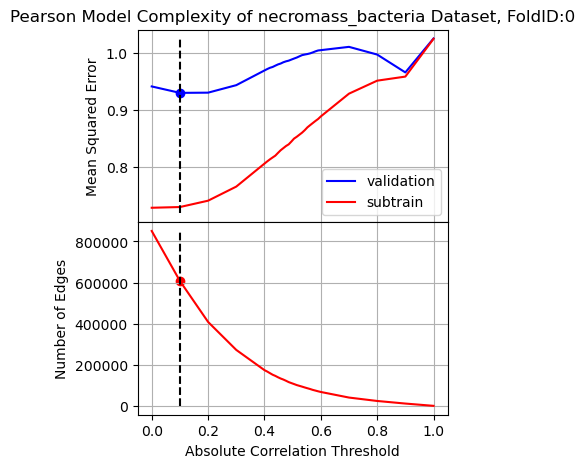

Best reg_param for necromass_bacteria FoldID:1 is 0.1
Best no of edges for necromass_bacteria FoldID:1 is 599500.0


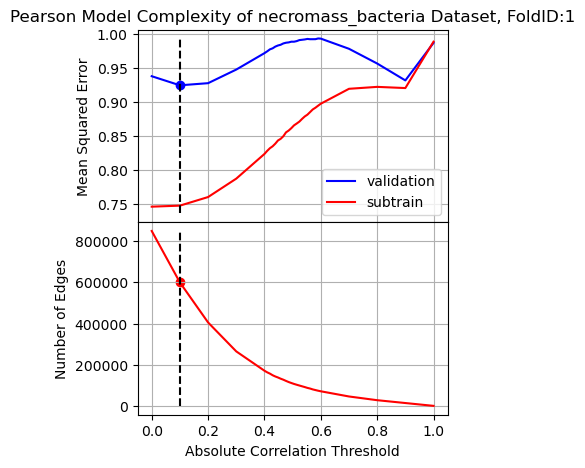

Best reg_param for necromass_bacteria FoldID:2 is 0.8999999999999999
Best no of edges for necromass_bacteria FoldID:2 is 16415.0


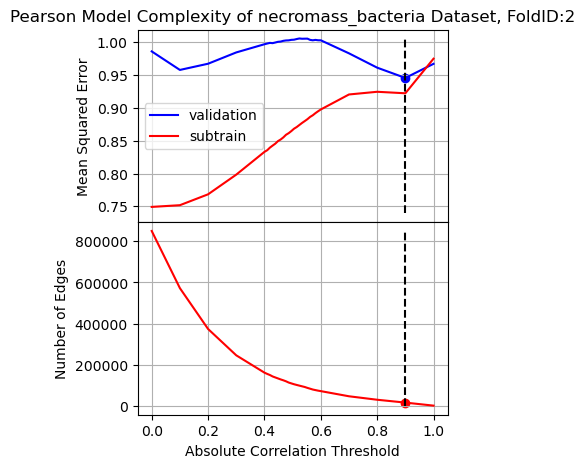

Best reg_param for necromass_bacteria FoldID:0 is 0.7999999999999999
Best no of edges for necromass_bacteria FoldID:0 is 16719.0


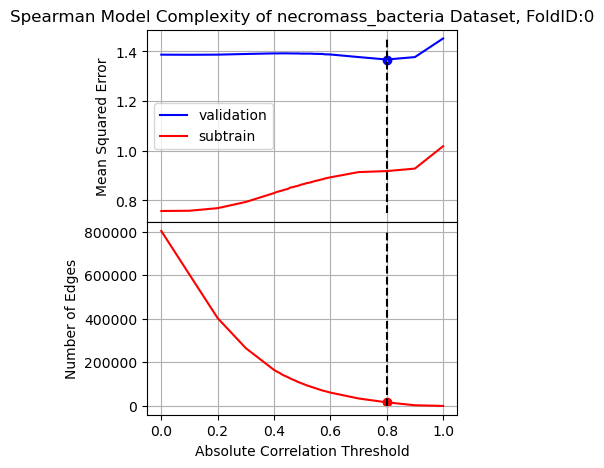

Best reg_param for necromass_bacteria FoldID:1 is 0.0
Best no of edges for necromass_bacteria FoldID:1 is 810634.0


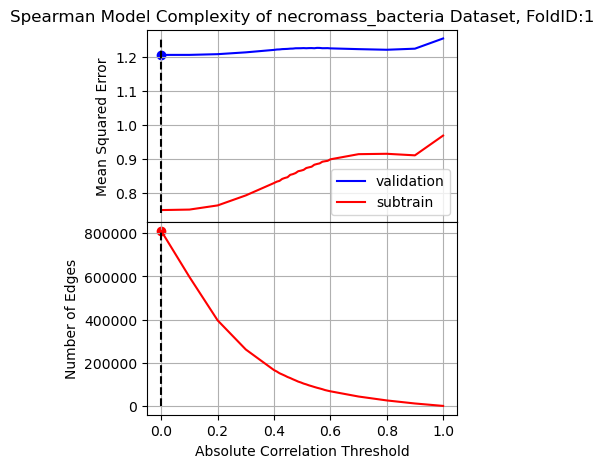

Best reg_param for necromass_bacteria FoldID:2 is 0.0
Best no of edges for necromass_bacteria FoldID:2 is 771697.0


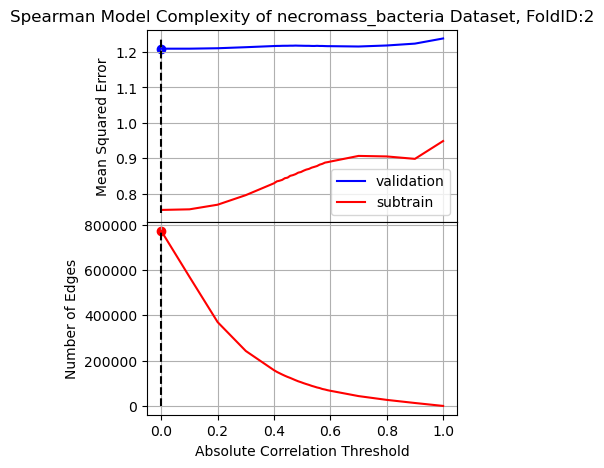

In [17]:
algorithm_list = model_complexity_df["algorithm"].unique()

for algorithm in algorithm_list:
    filtered_algorithm_df = model_complexity_df[model_complexity_df["algorithm"] == algorithm]
    # Get unique values as list from column name `Dataset`
    dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
    for dataset in dataset_list:
        # Get new dataframe with only the dataset
        sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
        fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
        
        for fold_id  in fold_id_list :
            test_error_df_list = []
            filtered_fold_id_df = sub_dataset_df[sub_dataset_df["fold_id"] == fold_id]
            
            reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
            for reg_param in reg_param_list:
                filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                subtrain_score = filtered_reg_param['subtrain_score'].mean()
                validation_score = filtered_reg_param['validation_score'].mean()
                edges = filtered_reg_param['edges'].mean()
        
                test_error_dict = {
                    'fold_id': fold_id,
                    'subtrain' :  subtrain_score,
                    'validation' : validation_score,
                    'data_set_name': dataset,
                    'reg_param': reg_param,
                    'algorithm' : algorithm,
                    'edges': edges
                }
                test_error_df_list.append(pd.DataFrame(test_error_dict, index=[0]))
            test_err_df = pd.concat(test_error_df_list).reset_index()
            
            # make a plot of the mean train score and mean test score for each reg_param
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 5))
            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.5))
            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.7))
            test_err_df.plot(x="reg_param", y=['validation', 'subtrain'], ax=ax1,
                              title=f'{algorithm} Model Complexity of {dataset} Dataset, FoldID:{fold_id}',
                              xlabel='', 
                              ylabel='Mean Squared Error', color = ['blue', 'red'], 
                              grid=True, 
                              legend=True,
                              )
            # change the legend text size
            # ax1.legend(loc='lower right', prop={'size': 8.1})
            
            # Remove x-ticks while keeping the vertical grid lines
            ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

            test_err_df.plot(x="reg_param", y= 'edges', ax=ax2,
                              xlabel='Absolute Correlation Threshold', 
                              ylabel='Number of Edges',
                              color = ['red'], 
                              legend=False,
                              grid=True
                              )
            # ax2.set_yticks([785, 5000, 9000])
            # ax2.invert_xaxis()
            
            # mark only the best reg_param with a blue dot on both subplots
            best_reg_param = test_err_df.loc[test_err_df['validation'].idxmin()]['reg_param']
            best_validation = test_err_df.loc[test_err_df['validation'].idxmin()]['validation']
            best_edges = test_err_df.loc[test_err_df['validation'].idxmin()]['edges']

            ax1.scatter(best_reg_param, best_validation, color='blue')
            ax2.scatter(best_reg_param, best_edges, color='red')
            
            # Add a line to connect the two subplots
            line_x = [best_reg_param, best_reg_param]
            # define the y-coordinates for the line
            line_y = np.array([np.min(test_err_df['subtrain']) - 0.01, np.max(test_err_df['validation'])])
            
            ax1.plot(line_x, line_y, 'k--')
            ax2.plot([best_reg_param, best_reg_param], np.array([np.min(test_err_df['edges']), np.max(test_err_df['edges'])]), 'k--')
            
            plt.plot(line_x, line_y, color='black', linestyle='--')
            
            # draw a straight horizontal line passing through y = 785 edges
            # line_x = np.array([np.min(test_err_df['reg_param']), np.max(test_err_df['reg_param'])])
            # line_y = np.array([785, 785])
            # ax2.plot(line_x, line_y, color='black', linestyle='--')
            
            print(f"Best reg_param for {dataset} FoldID:{fold_id} is {best_reg_param}")
            print(f"Best no of edges for {dataset} FoldID:{fold_id} is {best_edges}")
            plt.subplots_adjust(hspace=0.0)
            # Scale the entire plot
            # plt.tight_layout()
            # set dpi to 300 to get a high resolution image
            # plt.savefig(f"{algorithm}_{dataset}_foldid_{fold_id}_model_complexity.png", dpi=900,  bbox_inches="tight")
            # plt.savefig(f"{algorithm}_{dataset}_foldid_{fold_id}_model_complexity.png", format='svg')
            # plt.savefig('output.svg', format='svg')
            plt.show()
